# Processing GPR Data

Albin Wells -- June 2022

Code for processing GPR data and selecting the reflector signal

Pseudocode:
1. Define filepath and constant/given parameters
2. Extract waveform data and geolocations. Remove / consolidate waveforms in the same location
3. Preprocessing: 
    - Identify time_zero as airwave onset and clip to time_zero
    - Remove DC component of waveform
    - Take transpose of waveform
    - Crop waveform (size reduction)
    - Rubberbanding
4. Plot radargram with interction to select radargram return signals
5. Interpolate selections to discrete radar waveforms, and estimate twtt, bed depth, etc
6. Create GUI to look at each waveform independently and modify time_zero and reflector signal selections
7. Replot radargram with final selections. Recalculate twtt, bed depth, etc. Save these files


A note on selecting waveforms:

- In the event of multiple waveforms, choose the one with the larger peak (ex: cs21)
- If peaks are the same, choose the first return
- In cases where signals are particularly unclear, we select a return that is consistent with earlier/later selections


In [1]:
import os
import fnmatch
import math
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import griddata
from scipy.signal import butter, filtfilt, cheby1, cheby2, bessel, ellip, sosfiltfilt

# Read in GPR Data

The filepath 'gpr_fp' should be the desired folder storing the text files with the GPR data for each transect

Repeat this process for each transect

In [2]:
# Enter the filepath
gpr_fp = 'gulkana_transects/'

vel_ice = 158e6 # 150e6 for temperate ice and 167e6 for cold ice; best to estimate based on CMP
antenna_height = 10.0 # length of antennas
antenna_sepn = 6.1 # antenna separation in m
print('IS THIS RADAR STUDY IS 5MHZ -- 10m half length')
# wetness in ice increases dielectric constant/relative permittivity, which decreases radar velocity 
# and thus decreases depth we can reach with GPR signal

IS THIS RADAR STUDY IS 5MHZ -- 10m half length


In [4]:
def read_point(file):
    fid=open(file,'r')
    for head in range(2):
        fid.readline()
    lat = float(fid.readline())
    lon = float(fid.readline())
    elev = float(fid.readline())
    dt = float(fid.readline())
    wv = np.fromfile(fid, sep='\t')
    fid.close()
    return wv, lat, lon, elev, dt

In [5]:
# Get GPR file names
gpr_file_numbers = []
for i in os.listdir(gpr_fp):
    if i.endswith('.txt'):
        file_number = i.split('wv')[1].split('.txt')[0]
        gpr_file_numbers.append(int(file_number))
gpr_file_numbers = sorted(gpr_file_numbers)

gpr_fns = ['wv' + str(x) + '.txt' for x in gpr_file_numbers]

# Cut out the first few
cut_no = 1
gpr_fns = gpr_fns[cut_no:]
total_file_no = gpr_fns[-1][2:-4]
print('We got rid of the first ' + str(cut_no) + ' file(s) \n')
print(gpr_fns)


We got rid of the first 1 file(s) 

['wv2.txt', 'wv3.txt', 'wv4.txt', 'wv5.txt', 'wv6.txt', 'wv7.txt']


Also read in the GPR coordinate locations. Create vectors of the distance along the transect at each point and the total distance of each transect

In [6]:
# get the associated file with geocordinates. import this as a dataframe
# then, determine the total distance (total_cs_dist) and distance along the transect for each wv file (wv_dist_array)
cs_number = gpr_fp[-5:-1]
file_path = os.getcwd() + '/Transect_positions/'
file_name = cs_number + '_coords_*files.xlsx'
file_name = fnmatch.filter(os.listdir(file_path), file_name)[0]
geo_data_df = pd.read_excel(file_path + file_name).iloc[:, :]
total_cs_dist = 0
wv_dist_array = [0]
for i in range(len(geo_data_df[:]['UTM_EASTING']) - cut_no - 1):
    total_cs_dist += math.sqrt((geo_data_df.iloc[i+cut_no+1]['UTM_EASTING'] - 
                                geo_data_df.iloc[i+cut_no]['UTM_EASTING'])**2 + 
                               (geo_data_df.iloc[i+cut_no+1]['UTM_NORTHING'] - 
                                geo_data_df.iloc[i+cut_no]['UTM_NORTHING'])**2)
    wv_dist_array.append(total_cs_dist)

# remove nan values in cases where gps data is missing (cs 18--check this, maybe we make an assumption?)
wv_dist_array = [max(wv_dist_array) if math.isnan(x) else x for x in wv_dist_array]
total_cs_dist = max(wv_dist_array) # this is always the case
# print(np.round(wv_dist_array, 0))


[0. 0. 0. 0. 4. 4.]


Plot the waveforms individually

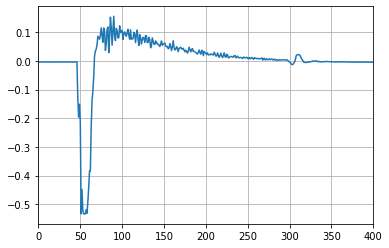

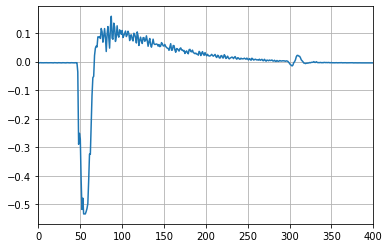

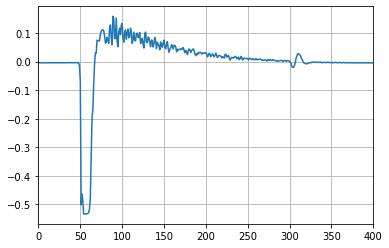

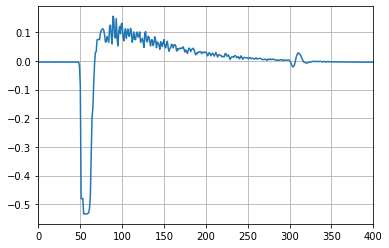

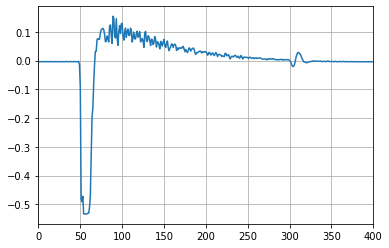

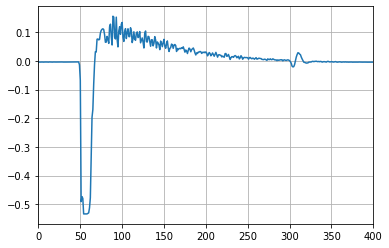

In [7]:
wv, lat, lon, elev, dt = read_point(gpr_fp + gpr_fns[1])
num_samples = wv.shape[0] # number of data points collected during the trace

# list of all wv files
wv_list = []
wv_filt_list = []
for i in range(len(gpr_fns)):
    wv, lat, lon, elev, dt = read_point(gpr_fp + gpr_fns[i])
    wv_list.append(wv)
    b_low, a_low = butter(4,.5,'lowpass') # low pass filter
    b,a = butter(4,.02,'high') # original filter used by Martin
    wv_low_filt = filtfilt(b_low, a_low, wv, axis=0)
    wv_filt_list.append(filtfilt(b, a, wv_low_filt, axis=0)) # axis=0 to filter each wv##.txt

# plot desired file
%matplotlib inline
for i in range(min(len(gpr_fns), 10)):
    wv, lat, lon, elev, dt = read_point(gpr_fp + gpr_fns[i])
    plt.figure(i)
    plt.plot(np.arange(num_samples), wv)
    plt.xlim(0, 400)
    plt.grid()   


Stack the beginning and end waveforms that are from the same location. Only represent the average of the waveforms at that location

In [8]:
# *** COMBINING THE BEGINNING AND END WAVEFORMS (THAT ARE FROM THE SAME LOCATION) AND USING THEIR MEAN
# Remove duplicate waveforms from the same location when the system was not moving on the ice
comb_thresh = 1 # threshold for combining waveforms. e.g. 1 means all waveforms within 1m will be combined
comb_begin = [i for i in range(len(wv_dist_array)) if wv_dist_array[i] < comb_thresh]  # find the begining wv to be combined
comb_end = [i for i in range(len(wv_dist_array)) if wv_dist_array[i] > total_cs_dist - comb_thresh] # find the end "    "
if total_cs_dist <= 1:  # if we basically have a point, not cs, adjust so comb_end isn't the same as comb_begin
    comb_end = [len(wv_dist_array)]

mean_begin = np.mean(wv_list[:len(comb_begin)], axis=0) # take the mean of the begining wv
mean_filt_begin = np.mean(wv_filt_list[:len(comb_begin)], axis=0)
mean_end = np.mean(wv_list[-len(comb_end):], axis=0) # take the mean of the end wv
mean_filt_end = np.mean(wv_filt_list[-len(comb_end):], axis=0)
mid_wv = wv_list[len(comb_begin):-len(comb_end)] # keep the middle wv
mid_filt_wv = wv_filt_list[len(comb_begin):-len(comb_end)]

# Now, create wv_list such that it only encorporates the part we want
wv_list = [mean_begin]
wv_filt_list = [mean_filt_begin]
for i in range(len(mid_wv)):
    wv_list.append(mid_wv[i])
    wv_filt_list.append(mid_filt_wv[i])
wv_list.append(mean_end)
wv_filt_list.append(mean_filt_end)

# Fix some of our arrays to reflect the data we're actually encorporating
wv_dist_array = wv_dist_array[comb_begin[-1]:comb_end[0]+1] # update wv_dist_array 
gpr_fns = gpr_fns[comb_begin[-1]:comb_end[0]+1] # update gpr_fns 
# NOTE: the first and last wv are now the mean of all those wv that were before/after 
print('New GPR waveforms:\n      ', gpr_fns)

New GPR waveforms:
       ['wv5.txt', 'wv6.txt']


We need to get the variables again, but only for the GPR files we are actually using. This is necessary since we removed and/or stacked some files

In [12]:
points = len(gpr_fns)
wv = np.empty((points,num_samples))
lat = np.empty((points,))
lon = np.empty((points,))
elev = np.empty((points,))
for n, gpr_fn in enumerate(gpr_fns):
    wv[n,:], lat[n], lon[n], elev[n], dt = read_point(gpr_fp + gpr_fn)


## GPR Processing steps

Now, we begin to process the GPR data:
- Identify time_zero as airwave onset and clip to [time_zero](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://archive.sciendo.com/IPC/ipc.2013.18.issue-2-3/v10248-012-0082-3/v10248-012-0082-3.pdf)
- Remove DC component of waveform (subtraction of the waveform mean)
- Take transpose of waveform (for plotting of the waveform on a radargram)
- Crop waveform (size reduction)
- Filter waveform signals with a low-pass filter to remove high frequency noise
- Rubberbanding (conversion from waveform number to distace along transect)

In [10]:
# *** DETERMINE THE STARTING / CUTOFF TIME TO FILTER PRE-TRIGGER
airwave_time = (antenna_sepn + (2*antenna_height))/3e8 # time for the airwave to travel

def time_zero_selection(method, wv_list, wv_filt_list):
    # Method 1: apparently signal starting time is the airwave negative peak (see below)
    # Method 2: take the signal starting time to be the onset of the airwave
    # Method 3: signal starting time as onset of the airwave from filtered data
    if method == 1:
        # index at minimum value
        t0_val_indices = [np.where(wv_list[i] == wv_list[i].min())[0][0] for i in range(len(wv_list))]
    elif method == 2:
        # index at zero value for each zero value
        t0_val_indices = [np.where(wv_list[i] < -0.025)[0][0]-1 for i in range(len(wv_list))]
    elif method == 3:
        # index at zero value for each zero value (using filtered wv)
        m = 20 # ignore the first few values when finding the zero-point of filtered data
        t0_val_indices = [np.where(wv_filt_list[i][m:] <= 0)[0][0]+m-1 for i in range(len(wv_filt_list))]
    t0_val_times = [x * dt for x in t0_val_indices] # convert index to time
    return t0_val_times

cutoff_times = np.round(time_zero_selection(3, wv_list, wv_filt_list), 9) 
print(cutoff_times)


[4.9e-07 4.9e-07]


In [13]:
# *** REMOVE PRE-TRIGGER BACKGROUND NOISE ***
all_time = np.arange(0, dt * num_samples, dt)

def posttrigger(total_times, cutoff_times):
    post_trigger_times = [np.where(all_time >= cutoff_times[i])[0] for i in range(len(cutoff_times))]
    all_time_list = [all_time[post_trigger_times[i]] for i in range(len(post_trigger_times))]
    # extract desired columns from each waveform only (columns represent times)
    wv_posttrigger_1 = [wv[i][post_trigger_times[i][0]:] for i in range(len(wv))]  # post trigger data for each wv
    wv_posttrigger_min = min([len(wv_posttrigger_1[i]) for i in range(len(wv_posttrigger_1))])  # find shortest wv
    wv_posttrigger = [wv_posttrigger_1[i][:wv_posttrigger_min] for i in range(len(wv_posttrigger_1))]
    wv_posttrigger = np.vstack(wv_posttrigger)
    return wv_posttrigger

wv_posttrigger = posttrigger(all_time, cutoff_times)

# # REMOVING PRE-TRIGGER WITH PERCENTAGE METHOD:
# pre_trigger_perc = 0.00
# pre_trigger_idx = int(pre_trigger_perc * num_samples)

# all_time = np.arange(0, dt * num_samples, dt)
# post_trigger_times = np.where(all_time >= (dt * (pre_trigger_perc * num_samples)))[0]
# all_time = time[post_trigger_times]
# wv_posttrigger = wv[:, post_trigger_times] # extract desired columns only (columns represent times)
# print(wv_posttrigger)
# print('\nPre-trigger times removed: ' + str(pre_trigger_perc*100) + '%') # THIS IS JUST A LOG THAT THEY WERE USING
# # data = data(post_trigger_times, :)

In [14]:
# Transpose data so x-axis is the number of traces and y-axis is time
#wv = wv.T
def transpose_dcRemoval(wv_input):
    wv_output = wv_input.T
    wv_input_mean = np.mean(wv_input,axis=0)
    wv_output = wv_output - wv_input_mean[:,np.newaxis]
    return wv_output

wv_trans = transpose_dcRemoval(wv_posttrigger)

In [ ]:
# Crop and filter waveforms to remove high frequency noise
max_size = 400
wv_crop = wv_trans[0:max_size,:] # radargram size reduction

wv_filt_low = filtfilt(b_low,a_low,wv_crop, axis=0) # axis=0 to filter each wv##.txt
wv_filt = filtfilt(b,a,wv_filt_low, axis=0) # axis=0 to filter each wv##.txt
np.savetxt('saved_file1.txt', wv_trans, delimiter=', ')
np.savetxt('saved_file2.txt', wv_filt, delimiter=', ')


## GPR signal selection

Now, we can start to identify and select the GPR signals. Since signals can be difficult to detect, we will do this in a few ways:

- From the radargram, make selections with a GUI by clicking along the signal
- From each individual waveform, use a GUI to confirm/modify selections for the signal start and end times

In [15]:
%matplotlib tk
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 20)

# print and store selected values
stored_xvals = []
stored_yvals = []
stored_xvals_plotonly = [] # for plotting we still want the original points for imshow
def onclick(event): # mouse click event
    global stored_xvals, stored_yvals, sorted_stored_xvals, sorted_stored_yvals
    global stored_xvals_plotonly, stored_stored_xvals_plotonly
    ix, iy = event.xdata, event.ydata
    dist_ix = np.interp(ix, np.arange(len(wv_filt_resampled[0])), xs[:,0]) # get the distance value of the point
    # map the distance to wv file number
    wv_ix = np.interp(dist_ix, wv_dist_array, np.arange(len(wv_filt_resampled[0])) + 1 + len(comb_begin))
    print(dist_ix, iy)

    stored_xvals.append(wv_ix)
    stored_yvals.append(iy) 
    sorted_data = sorted(zip(stored_xvals, stored_yvals), key=lambda x: x[0])
    sorted_stored_xvals = [x[0] for x in sorted_data]
    sorted_stored_yvals = [x[1] for x in sorted_data]

    stored_xvals_plotonly.append(ix)
    sorted_data_plotonly = sorted(zip(stored_xvals_plotonly, stored_yvals), key=lambda x: x[0])
    sorted_stored_xvals_plotonly = [x[0] for x in sorted_data_plotonly]
    plt.plot(sorted_stored_xvals_plotonly, sorted_stored_yvals, color='r', zorder=200) 
    plt.plot(ix, iy, color='r', marker='.', markersize=8, zorder=200)
    
    # *** print waveforms of the selected point
    # selection_index = min(range(len(wv_dist_array)), key=lambda i: abs(wv_dist_array[i]-dist_ix))
    # plt.plot(np.transpose(wv_filt)[selection_index]*4 + selection_index, np.arange(max_size), color='goldenrod') 
    plt.show()

prev_key = 0
c = 5 # this is to make sure each additional plot is on top of the previous
def onpress(event): # key press event
    global prev_key, c
    c += 1
    amp = 100
    # print waveforms on the radargram at desired locations
    if ord(event.key[0]) >= 48 and ord(event.key[0]) <=57: # these are the integer value key inputs
        selection = int((ord(event.key)-48)*0.1*len(wv_dist_array))
        plt.plot(np.transpose(wv_filt)[selection]*amp + selection, np.arange(max_size), color='goldenrod', zorder=c)
        prev_key = int(int(event.key)*0.1*len(wv_dist_array))
    elif event.key == 'left': # to move sequentially up/down plotting a waveform
        plt.plot(np.transpose(wv_filt)[prev_key-1]*amp + prev_key - 1, np.arange(max_size), color='goldenrod', zorder=c)
        prev_key -= 1
    elif event.key == 'right':
        plt.plot(np.transpose(wv_filt)[prev_key+1]*amp + prev_key + 1, np.arange(max_size), color='goldenrod', zorder=c)
        prev_key += 1
    elif event.key == 'a': # to show all waveforms
        for i in range(int(len(wv_dist_array))):
            plt.plot(np.transpose(wv_filt)[i]*amp + i, np.arange(max_size), color='goldenrod', zorder=c)
    elif event.key == 'c': # clear the waveform plots (replot base on top)
        plt.imshow(wv_filt_resampled, cmap='bone',vmin = -0.01, vmax = 0.01, aspect='auto', zorder=c)       
    plt.show()
    
cid = fig.canvas.mpl_connect('button_press_event', onclick) # initiate the butten click event
pid = fig.canvas.mpl_connect('key_press_event', onpress) # initiate the key press event

# # RUBBER BANDING: create a meshgrid using wv file spacing
xs,ys = np.mgrid[0:total_cs_dist:complex(0, wv_filt.shape[1]), 0:wv_filt.shape[0]:1]
wv_filt_resampled = griddata(list(itertools.product(wv_dist_array, np.arange(0,max_size))), 
                             wv_filt.flatten('F'), (xs, ys), method='nearest').T

# # *** ALTERNATE WAY TO DO RUBBER-BANDING
# indices = [(np.abs(wv_dist_array-x)).argmin() for x in [x[0] for x in xs]]
# wv_filt_resampled2 = np.array([wv_filt.T[i] for i in indices]).T
# plt.imshow(wv_filt_resampled2, cmap='bone',vmin = -0.01, vmax = 0.01, aspect='auto')
# # *** ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^

# plt.imshow(wv_filt, cmap='bone',vmin = -0.01, vmax = 0.01, aspect='auto') # original result
plt.imshow(wv_filt_resampled, cmap='bone',vmin = -0.01, vmax = 0.01, aspect='auto') # rubbber-banded result

plt.xticks(ticks=np.linspace(0, wv_filt.shape[1]-0.5, 5), 
       labels=np.linspace(0, total_cs_dist, 5, dtype=int), fontsize=18)
plt.xlabel('Distance along Transect (m)', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Time (1e-8 s) ~or~ (10 ns)', fontsize=24)
plt.title(gpr_fp[-5:-1] + '_plot', fontsize=36, c='r')
plt.grid()
plt.xlim(left=0)
plt.show()

print('*** Click to add points to identify the return signal')
print('*** Press a number key, or use the left/right arrow to display radar waveforms on radargram.\n' + 
      '    Press "a" to show all waveforms, "c to clear"\n')


*** Click to add points to identify the return signal
*** Press a number key, or use the left/right arrow to display radar waveforms on radargram.
    Press "a" to show all waveforms, "c to clear"



Let's quickly save our radargram selections for our records visually as a png image.

Let's also estimate the signal travel times and bed depth based on our selections

In [142]:
# *** Save radargram in appropriate folder
if len(stored_xvals) > 2:  # only save the file if we actually made some selections
    # plt_title_radar = 'plots/transect_plots/' + gpr_fp[-5:-1] + '_plot.png'
    plt_title_radar = 'plots/transect_plots_rubberband/' + gpr_fp[-5:-1] + '_rb_plot.png'
    fig.savefig(plt_title_radar, facecolor='w')

In [143]:
# interpolate the selected values and output results

# WE NEED TO FIX THIS INTERPOLATION!!
wv_file_numbers = [int(gpr_fns[i][2:-4]) for i in range(len(gpr_fns))] # each file number included in the study
interp_bed_depth_index_radargram = np.round(np.interp(wv_file_numbers, sorted_stored_xvals, sorted_stored_yvals), 4)
interp_bed_depth_index = np.round(interp_bed_depth_index_radargram + (np.array(cutoff_times)/dt), 4)
interp_bed_depth_twtt = np.round((interp_bed_depth_index*dt) + airwave_time, 10) # signal 2-way travel time
# interp_bed_depth_depth = np.round((vel_ice*interp_bed_depth_twtt/2), 4) # interpolated depth
interp_bed_depth_depth = np.round(np.power((vel_ice*interp_bed_depth_twtt/2)**2 -
                                           ((antenna_sepn + (2*antenna_height))/2)**2, 0.5), 4)
            # www.ncbi.nlm.nih.gov/pmc/articles/PMC6101056/pdf/jove-135-56847.pdf

# print results
table_results = "\n".join("{} \t\t {} \t\t {} \t\t\t {} \t\t {}".format(v, w, x, y, z) for v, w, x, y, z in 
                          zip(wv_file_numbers, interp_bed_depth_index_radargram, interp_bed_depth_index, 
                              np.round(wv_dist_array, 1), interp_bed_depth_depth))
print('wv_num \t interpolated y-axis \t interp. y-axis with t-zero' + 
      '\t distance along cs (m) \t est. interp. depth(m)')
print(table_results)


wv_num 	 interpolated y-axis 	 interp. y-axis with t-zero	 distance along cs (m) 	 est. interp. depth(m)
5 		 258.4713 		 307.4713 			 0.4 		 249.4332
6 		 255.0399 		 304.0399 			 3.7 		 246.7197


## Revising GPR signal selections by taking a closer look at the waveforms

First, we can assess and modify (if needed) any starting signal locations.

Then, we can do the same for the selected end points (the perceived signal location)

In [144]:
### Plot radargram selections on waveform graph to qualitatively assess accuracy
## TO EDIT THE STARTING POINT SIGNAL
%matplotlib tk
# wv_file_numbers  # wv number, sorted array
# interp_bed_depth_index  # radargram time, sorted array
# cutoff_times  # initial pre-trigger time remove from radargram

print('MODIFYING THE STARTING POINT SIGNAL TIME')
for i in range(len(gpr_fns)):
    ix = 0
    def onclick(event):
        global cutoff_times, ix
        plt.axvline(ix, color='w', lw=0.75)
        ix, iy = event.xdata, event.ydata
        print(ix, iy)
        print('Time from interpreted bed depth:', str(interp_bed_depth_index[i] - ix))
        cutoff_times[i] = ix*dt
        plt.xlim(ix - 20, ix + 20)
        plt.axvline(ix, color='b', lw=0.5)
        plt.show(block=True)

    fig1, ax = plt.subplots(nrows=1, ncols=1) 
    fig1.set_size_inches(12,8)
    plt.plot(np.arange(num_samples), wv_filt_list[i], label='Filtered WV Data')
    plt.plot(np.arange(num_samples), wv_list[i], color='orange', alpha=0.5, label='Raw WV Data')
    plt.axvline(cutoff_times[i]/dt, color='k', lw=0.5)  # plot cutoff time line
    plt.axvline(interp_bed_depth_index[i], color='r', lw=0.5)  # plot radargram line selection
    plt.title('Mean waveform for ' + gpr_fp[-5:-1] + ', ' + gpr_fns[i][:-4] + ' (out of ' + gpr_fns[-1][2:-4] + ', ' +
              str(round(wv_dist_array[i],1)) + 'm' + '): Radargram Selection \n TIME-ZERO ADJUSTMENT (BLACK LINE)')
    ax.legend(loc='lower right')
#     plt.xlim(0, max_size)
    plt.xlim((cutoff_times[i]/dt)-20, (cutoff_times[i]/dt)+20)
    plt.grid()
    cid = fig1.canvas.mpl_connect('button_press_event', onclick)
    plt.waitforbuttonpress(0) # this will wait for indefinite time
    plt.close(fig1)


45.96535244922341 -0.005801908957490998
Time from interpreted bed depth: 261.50594755077657


In [150]:
### Plot radargram selections on waveform graph to qualitatively assess accuracy
## TO EDIT THE ENDING POINT SIGNAL
%matplotlib tk

print('MODIFYING THE ENDING POINT SIGNAL TIME')
for i in range(len(gpr_fns)):
    ix = 0
    def onclick(event):
        global interp_bed_depth_index, ix
        plt.axvline(ix, color='w', lw=0.8, alpha=1)
        ix, iy = event.xdata, event.ydata
        print(ix, iy)
        print('Time from time-zero:', str(ix - (cutoff_times[i]/dt)))
        interp_bed_depth_index[i] = ix
        plt.xlim(ix - 20, ix + 20)
        plt.ylim(iy - 0.05, iy + 0.05)
        plt.axvline(ix, color='b', lw=0.5)
        if ix < cutoff_times[i]/dt:
            interp_bed_depth_index[i] = None
        plt.waitforbuttonpress(0)
        plt.show(block=True)

    fig2, ax = plt.subplots(nrows=1, ncols=1) 
    fig2.set_size_inches(12,8)
    plt.plot(np.arange(num_samples), wv_filt_list[i], color='blue', alpha=0.7, label='Filtered WV Data')
    plt.plot(np.arange(num_samples), wv_list[i], color='orange', alpha=0.5, label='Raw WV Data')
    plt.axvline(cutoff_times[i]/dt, color='k', lw=0.5)  # plot cutoff time line
    plt.axvline(interp_bed_depth_index[i], color='r', lw=0.5)  # plot radargram line selection
    plt.title('Mean waveform for ' + gpr_fp[-5:-1] + ', ' + gpr_fns[i][:-4] + ' (out of ' + gpr_fns[-1][2:-4] + ', ' +
              str(round(wv_dist_array[i],1)) + 'm' + '): Radargram Selection \n REFLECTION POINT ADJUSTMENT (RED LINE)')
    ax.legend(loc='lower right')
    plt.xlim(0, max_size)
    plt.grid()
    cid = fig2.canvas.mpl_connect('button_press_event', onclick)
    plt.waitforbuttonpress(0) # this will wait for indefinite time
    plt.close(fig2)


Now, let's recalculate the signal travel times and bed depths now that we've fine-tuned our signal point selections

In [146]:
# REVISED bed depth, travel times, etc

# interp_bed_depth_index  # this is now edited from above. this is the wv time (including the cutoff time)
interp_bed_depth = np.round(np.array(interp_bed_depth_index) - (np.array(cutoff_times)/dt), 4) # remove cutoff time
interp_bed_depth_twtt = np.round((np.array(interp_bed_depth)*dt) + airwave_time, 10) # signal 2-way travel time
# interp_bed_depth_depth = np.round((vel_ice*interp_bed_depth_twtt/2), 4) # interpolated depth
interp_bed_depth_depth = np.round(np.power((vel_ice*interp_bed_depth_twtt/2)**2 -
                                           ((antenna_sepn + (2*antenna_height))/2)**2, 0.5), 4)
            # www.ncbi.nlm.nih.gov/pmc/articles/PMC6101056/pdf/jove-135-56847.pdf

# print results
table_results = "\n".join("{} \t {} \t\t\t {} \t\t\t {}".format(w, x, y, z) for w, x, y, z in 
                          zip(wv_file_numbers, interp_bed_depth, interp_bed_depth_twtt, interp_bed_depth_depth))
print('wv_num \t interpolated y-axis \t\t interpolated twtt (s) \t\t est. interp. depth(m)')
print(table_results)


wv_num 	 interpolated y-axis 		 interpolated twtt (s) 		 est. interp. depth(m)
5 	 254.0665 			 2.6277e-06 			 207.1777
6 	 251.9877 			 2.6069e-06 			 205.5312


Finally, we can also replot the radargram with our final, modified selections. And we save the final output radargram with the associated data in an excel sheet

The following GUI also let's us use keys to add waveforms on top of the radargram: 
- numbers 1-9 show waveforms roughly distributed along the transect
- left/right arrows add a waveform to the left/right of the previous waveform
- 'a' is to show all waveforms 
- 'c' is to clear waveforms

In [147]:
# *** REPLOT RADARGRAM WITH LINES AT FINAL SELECTIONS
%matplotlib tk

wv_posttrigger_replot = posttrigger(all_time, cutoff_times)
wv_trans_replot = transpose_dcRemoval(wv_posttrigger_replot)
wv_crop_replot = wv_trans_replot[0:max_size,:] # radargram size reduction
wv_filt_replot = filtfilt(b,a,wv_crop_replot, axis=0) # axis=0 to filter each wv##.txt
xs,ys = np.mgrid[0:total_cs_dist:complex(0, wv_filt_replot.shape[1]), 0:wv_filt_replot.shape[0]:1]
indices_replot = [(np.abs(wv_dist_array-x)).argmin() for x in [x[0] for x in xs]]
wv_filt_resampled2 = np.array([wv_filt_replot.T[i] for i in indices_replot]).T

fig3, ax = plt.subplots(nrows=1, ncols=1)
fig3.set_size_inches(10, 20)
plt.imshow(wv_filt_resampled2, cmap='bone',vmin = -0.01, vmax = 0.01, aspect='auto', 
           extent=[0, wv_dist_array[-1], max_size, 0]) # rubbber-banded
plt.plot(wv_dist_array, interp_bed_depth, color='r', marker='o', markersize=5, alpha = 0.75, zorder=200)
# plt.xticks(ticks=np.linspace(0, wv_filt.shape[1]-0.5, 5), labels=np.linspace(0, total_cs_dist, 5, dtype=int), 
#            fontsize=18)

# add key press event to show more waveforms
prev_key = 0
c = 5 # this is to make sure each additional plot is on top of the previous
def onpress(event): # key press event
    global prev_key, c
    c += 1
    amp = 1000
    # print waveforms on the radargram at desired locations
    if ord(event.key[0]) >= 48 and ord(event.key[0]) <=57: # these are the integer value key inputs
        selection = int((ord(event.key)-48)*0.1*len(wv_dist_array))
        plt.plot(np.transpose(wv_filt_replot)[selection]*amp + wv_dist_array[selection], np.arange(max_size), 
                 color='goldenrod', zorder=c, alpha=0.9)
        prev_key = int(int(event.key)*0.1*len(wv_dist_array))
    elif event.key == 'left': # to move sequentially up/down plotting a waveform
        plt.plot(np.transpose(wv_filt_replot)[prev_key-1]*amp + wv_dist_array[prev_key-1], np.arange(max_size), 
                 color='goldenrod', zorder=c, alpha=0.9)
        prev_key -= 1
    elif event.key == 'right':
        plt.plot(np.transpose(wv_filt_replot)[prev_key+1]*amp + wv_dist_array[prev_key+1], np.arange(max_size), 
                 color='goldenrod', zorder=c, alpha=0.9)
        prev_key += 1
    elif event.key == 'a': # to show all waveforms
        for i in range(int(len(wv_dist_array))):
            plt.plot(np.transpose(wv_filt_replot)[i]*amp + wv_dist_array[i], np.arange(max_size), 
                     color='goldenrod', zorder=c, alpha=0.9)
    elif event.key == 'c': # clear the waveform plots (replot base on top)
        plt.imshow(wv_filt_resampled2, cmap='bone',vmin = -0.01, vmax = 0.01, aspect='auto', zorder=c,
                   extent=[0, wv_dist_array[-1], max_size, 0])
    plt.show()

pid = fig3.canvas.mpl_connect('key_press_event', onpress) # initiate the key press event

# add plots of waveforms to the output
# for i in range(int(len(wv_dist_array)/4)):
#     plt.plot(np.transpose(wv_filt_replot)[(i+1)*4]*100 + wv_dist_array[(i+1)*4], np.arange(max_size), 
#              color='goldenrod')

plt.xlabel('Distance along Transect (m)', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Time (1e-8 s) ~or~ (10 ns)', fontsize=24)
plt.title(gpr_fp[-5:-1] + '_plot', fontsize=36, c='r')
plt.xlim(left=0)
plt.grid()

# *** Save updated radargram in appropriate folder
plt_title_radar_new = 'plots/transect_plots_rubberband/' + gpr_fp[-5:-1] + '_rb_plot_updated.png'
fig3.savefig(plt_title_radar_new, facecolor='w')

Now we save the files. ONLY run these final lines of code of you like the selection; it will override the previous file with the same names, if there are any.

In [148]:
# *** Save the filtered waveform
file = open('gulkana_wv_filt_arrays/' + gpr_fp[-5:-1] + '_wv_filt.txt', "wb")
np.save(file, wv_filt_replot)
# np.save(file, wv_filt_resampled2)
file.close

<function BufferedWriter.close>

In [149]:
# *** Save output files for Gulkana cross-sects with bed depth at locations
cs_number = gpr_fp[-5:-1]
file_number = total_file_no
file_path = os.getcwd() + '/Transect_positions/' + cs_number + '_coords_' + file_number + 'files.xlsx'
geo_data_df = pd.read_excel(file_path).iloc[:, 1:6]

depth_df = pd.DataFrame({'twtt_without_airwave': interp_bed_depth,
                         'bed_depth_m': interp_bed_depth_depth,
                         'twtt_s': interp_bed_depth_twtt,
                         'wv_number_check': wv_file_numbers})
geo_data_df_updated = pd.merge(geo_data_df, depth_df, how='left', 
                               left_on='wv_number', right_on='wv_number_check')    
geo_data_df_updated.to_excel(file_path) # save as excel file, overwrite current file 

